In [17]:
import pandas as pd
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
import time
from river import drift
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model,forest
from river.drift.binary import DDM, EDDM,HDDM_A,HDDM_W
import logging


In [6]:


# Load the dataset
file_path = "F:\Projects\Cap_github\Capstone\Data\masterdatasubset.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Specify the columns to include
exclusive_labels = ['IAT', 'Tot sum', 'Tot size', 'Max', 'Header_Length', 'AVG', 'Magnitue', 
                    'Min', 'rst_count', 'Protocol Type', 'flow_duration', 'Std', 'Radius', 
                    'Variance', 'urg_count', 'Covariance', 'syn_count', 'Number', 'Weight', 'label']

# Filter the dataset to include only the specified columns
filtered_data = data[exclusive_labels]

In [7]:
n_samples = 10000

# Group by the 'label' column and sample
sampled_data = filtered_data.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples)))

# Reset index for the sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

C:\Users\Anubhav\AppData\Local\Temp\ipykernel_7952\2981163042.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = filtered_data.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples)))


In [8]:
sampled_data

,IAT,Tot sum,Tot size,Max,Header_Length,AVG,Magnitue,Min,rst_count,Protocol Type,flow_duration,Std,Radius,Variance,urg_count,Covariance,syn_count,Number,Weight,label
0,1.665206e+08,16371.8,2238.0,4120.4,8226438.8,1014.516668,44.596378,66.0,7790.5,6.0,117.529964,1093.939754,1549.726799,1.0,303.0,1.366369e+06,0.0,13.5,244.6,Benign
1,1.665193e+08,36171.2,3251.6,15994.0,469537.2,2294.735090,67.478795,66.0,335.5,6.0,2.048867,3880.959335,5504.172264,1.0,15.0,1.702151e+07,2.0,13.5,244.6,Benign
2,1.665242e+08,1015.2,65.4,66.0,541208.2,65.503825,11.445577,60.0,515.5,5.4,28.304712,1.641501,2.327281,1.0,22.9,2.734835e+00,1.4,13.5,244.6,Benign
3,9.421086e-03,363.0,66.0,66.0,6594028.0,66.000000,11.489125,66.0,6174.5,6.0,90.882680,0.000000,0.000000,0.0,224.0,0.000000e+00,0.0,5.5,38.5,Benign
4,1.665240e+08,1859.7,112.9,475.0,69835.4,119.466465,15.470478,54.0,391.5,7.1,73.058160,118.641404,168.118459,1.0,182.3,1.417191e+04,0.9,13.5,244.6,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,3.984921e-02,577.0,109.9,165.8,9000.1,107.373849,14.608392,67.2,68.0,5.4,56.079945,40.503372,57.280418,0.9,38.8,1.849082e+03,0.8,5.5,38.5,Web
79996,1.676391e+08,2457.0,162.6,240.8,81863.2,158.437067,17.827087,60.0,605.5,9.8,1501.769391,73.850538,104.313424,1.0,302.6,5.445962e+03,0.5,13.5,244.6,Web
79997,1.013420e-02,513.5,96.9,120.4,5340.1,88.063333,13.239377,63.6,18.4,9.9,615.964658,22.931606,32.430189,0.8,5.7,8.369987e+02,1.2,5.5,38.5,Web
79998,1.676386e+08,2480.0,122.9,545.0,762.2,161.873766,18.008092,54.0,6.3,4.9,8.872013,122.436680,173.339065,1.0,3.4,1.506693e+04,0.0,13.5,244.6,Web


In [29]:
# Filter the dataset to include only the columns in the 'feat' list
X = sampled_data.drop('label',axis=1)  # Assuming 'feat' is a list of column names
y = sampled_data['label']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.2, test_size=0.8, shuffle=True, random_state=0, stratify=y
)

# Splitting x_test and Y_test further into smaller test and remaining subsets
X_test, x_test_remainig, y_test, y_test_remaining = train_test_split(
    X_test, y_test, train_size=0.3, test_size=0.7, shuffle=True, random_state=0, stratify=y_test
)



In [12]:
X = sampled_data.drop(columns=['label'])
y = sampled_data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm = SVC(probability=True, random_state=42)

# Define meta-model
meta_model = LogisticRegression()

In [13]:
stack = StackingClassifier(
    estimators=[
        ('random_forest', rf),
        ('xgboost', xgb),
        ('svm', svm)
    ],
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stack.fit(X_train, y_train)

# Make predictions
y_pred = stack.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Stacked Model: {accuracy:.2f}")

c:\Users\anubh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


: 

In [21]:
#With drift of 80

def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = model.predict_one(x)  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            print(f"Change detected at index {i}, input value: {y_val}")
            
           
        if eddm.warning_detected:
           print(f"Warning detected at index {i}")
        # Print samples every 80 iterations
        if i % 80 == 0:
            print(f"Sample {i}: True label: {y_val}, Predicted label: {y_pred}") 

        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp,average='weighted'), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp,average='weighted'), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp,average='weighted'), 4) * 100) + "%")


    return t, m


In [22]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    #if m:  # Check if m is not empty
    plt.plot(t, m, '-b', label='Avg Accuracy: %.2f%%' % (m[-1]))

    #plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Sample 0: True label: Recon, Predicted label: Web
Sample 80: True label: Mirai, Predicted label: Mirai
Sample 160: True label: Recon, Predicted label: DoS
Sample 240: True label: Benign, Predicted label: DDoS
Sample 320: True label: Mirai, Predicted label: Mirai
Sample 400: True label: Spoofing, Predicted label: Brute
Sample 480: True label: Recon, Predicted label: Brute
Sample 560: True label: DoS, Predicted label: DoS
Sample 640: True label: Recon, Predicted label: Brute
Sample 720: True label: Spoofing, Predicted label: Brute
Sample 800: True label: Recon, Predicted label: Brute
Sample 880: True label: Recon, Predicted label: Brute
Sample 960: True label: Web, Predicted label: Spoofing
Sample 1040: True label: Web, Predicted label: Brute
Sample 1120: True label: Mirai, Predicted label: Mirai
Sample 1200: True label: Spoofing, Predicted label: Brute
Sample 1280: True label: Spoofing, Predicted label: Benign
Sample 1360: True label: Web, Predicted label: Spoofing
Sample 1440: True lab

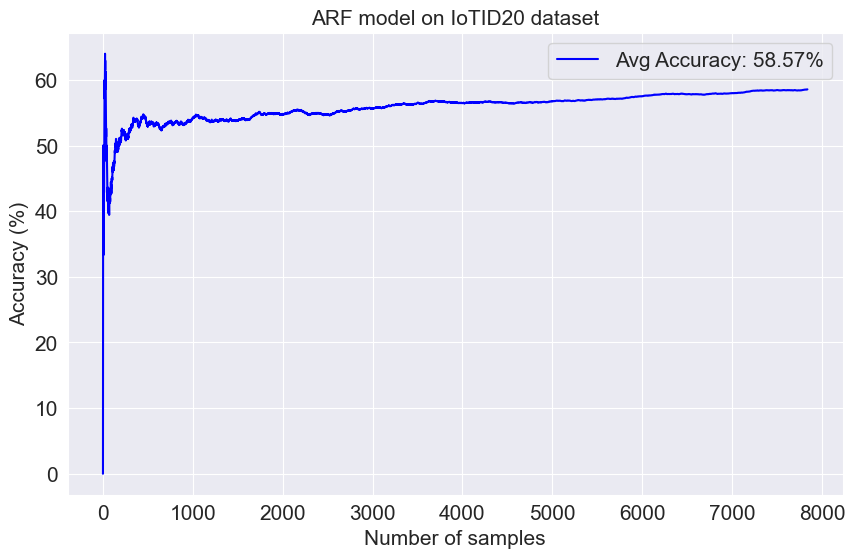

In [23]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name = "ARF model"
model = forest.ARFClassifier(n_models = 3,drift_detector=EDDM()) # Define the model
t, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

Sample 0: True label: Recon, Predicted label: Benign
Sample 80: True label: Mirai, Predicted label: Mirai
Sample 160: True label: Recon, Predicted label: DoS
Sample 240: True label: Benign, Predicted label: Benign
Sample 320: True label: Mirai, Predicted label: Mirai
Sample 400: True label: Spoofing, Predicted label: Brute
Sample 480: True label: Recon, Predicted label: Brute
Sample 560: True label: DoS, Predicted label: DoS
Sample 640: True label: Recon, Predicted label: Web
Sample 720: True label: Spoofing, Predicted label: Web
Sample 800: True label: Recon, Predicted label: Brute
Sample 880: True label: Recon, Predicted label: Mirai
Sample 960: True label: Web, Predicted label: DoS
Sample 1040: True label: Web, Predicted label: Brute
Sample 1120: True label: Mirai, Predicted label: Mirai
Sample 1200: True label: Spoofing, Predicted label: DDoS
Sample 1280: True label: Spoofing, Predicted label: Spoofing
Sample 1360: True label: Web, Predicted label: Web
Sample 1440: True label: Beni

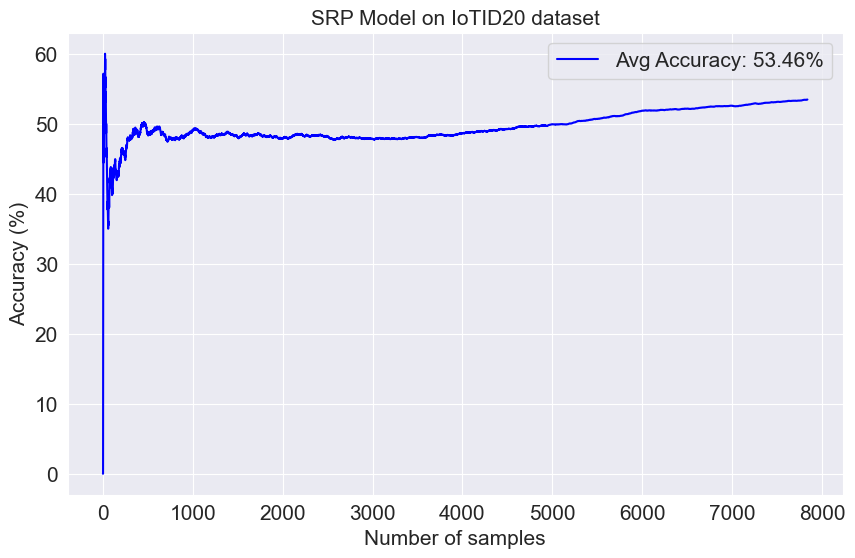

In [24]:
%%time
# Use the Hoeffding Tree (HT) model 
name5 = "SRP Model"
model5 = ensemble.SRPClassifier() # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Sample 0: True label: Brute, Predicted label: DoS
Sample 80: True label: Benign, Predicted label: DoS
Sample 160: True label: Brute, Predicted label: DoS
Sample 240: True label: Web, Predicted label: Brute
Sample 320: True label: Benign, Predicted label: DDoS
Sample 400: True label: Recon, Predicted label: DoS
Sample 480: True label: Spoofing, Predicted label: Spoofing
Sample 560: True label: DoS, Predicted label: DoS
Sample 640: True label: DoS, Predicted label: DoS
Sample 720: True label: Web, Predicted label: DoS
Sample 800: True label: Mirai, Predicted label: Mirai
Sample 880: True label: Mirai, Predicted label: Mirai
Sample 960: True label: Web, Predicted label: Brute
Sample 1040: True label: DoS, Predicted label: DoS
Sample 1120: True label: Mirai, Predicted label: Mirai
Sample 1200: True label: DDoS, Predicted label: DDoS
Sample 1280: True label: Mirai, Predicted label: Mirai
Sample 1360: True label: Recon, Predicted label: DoS
Sample 1440: True label: Mirai, Predicted label: Mi

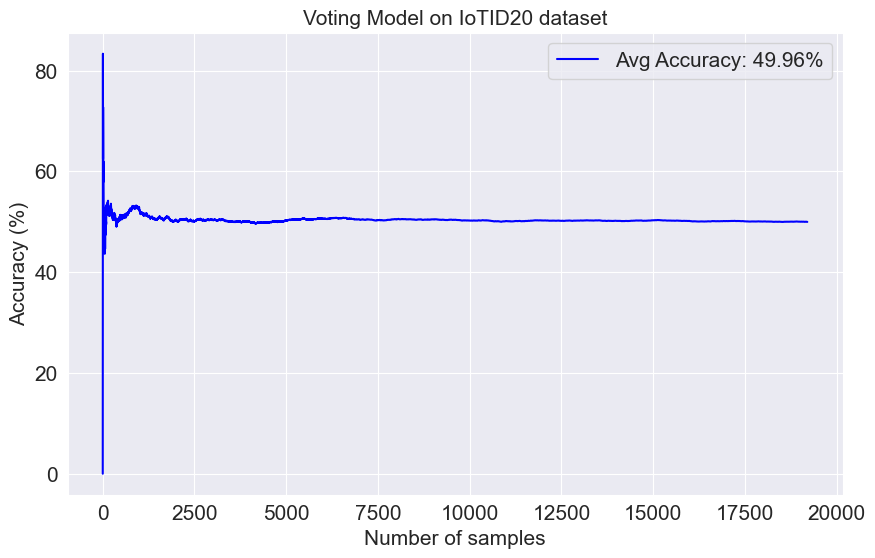

In [32]:
start = time.time()

# Use the Voting Classifier model
name10 = "Voting Model"
model10 = ensemble.VotingClassifier(
    [
        ensemble.SRPClassifier(),
        forest.AMFClassifier(),
        forest.ARFClassifier(),
        tree.ExtremelyFastDecisionTreeClassifier(),
        tree.HoeffdingAdaptiveTreeClassifier(),
        tree.HoeffdingTreeClassifier()
    ]
)


# Learn the model on the dataset
t10, m10 = adaptive_learning(model10, X_train, y_train, X_test, y_test)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t10, m10, name10)

end = time.time()
print("Time in seconds:", (end - start))
